Cleaning Dataset as done in the previous notebook

(397896, 15)
count    3.969540e+05
mean     4.951579e+04
std      9.399797e+06
min      0.000000e+00
25%      5.997000e+03
50%      1.400000e+04
75%      2.698500e+04
max      3.736929e+09
Name: price, dtype: float64
count    3.969540e+05
mean     4.951579e+04
std      9.399797e+06
min      0.000000e+00
25%      5.997000e+03
50%      1.400000e+04
75%      2.698500e+04
max      3.736929e+09
Name: price, dtype: float64
65000.0
449.0


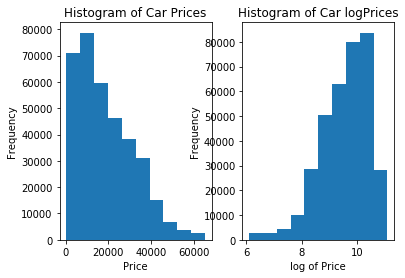

266000.0
16931.0
count    314320.000000
mean     100493.218169
std       55321.036258
min       16935.000000
25%       53048.750000
50%       96474.000000
75%      139596.000000
max      265900.000000
Name: odometer, dtype: float64


In [1]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn import metrics


import warnings
warnings.filterwarnings('ignore')

#importing the data 
df_raw=pd.read_csv("vehicles.csv")
df1=pd.DataFrame(df_raw)


#filtering latest data from 2015
#df1=df1[(df1['year']>=2015)]
df1=df1[(df1['year']>=2000) & (df1['year']<=2020)]
df1.shape

df=df1.drop(columns=['id','url','region','region_url','VIN','image_url','description','size','lat','long','county'])
#they are not useful for analysis
df.dropna(subset=['manufacturer','model','fuel','odometer','transmission','condition', 'cylinders', 'title_status','posting_date', 'drive', 'type', 'paint_color'], axis=0, how='all', inplace=True)
print(df.shape)
df.isnull().sum()

#drop duplicates
duplicate = df[df.duplicated()]
duplicate.shape
df2=df.drop_duplicates(keep=False)
df2.shape

df2['transmission'] = df2['transmission'].fillna(method='ffill')
df2['cylinders'] = df2['cylinders'].fillna(method='ffill')
df2['title_status'] = df2['title_status'].fillna(method='ffill')
df2['fuel'] = df2['fuel'].fillna(method='ffill')
df2['paint_color'] = df2['paint_color'].fillna(method='ffill')
df2['drive'] = df2['drive'].fillna(method='ffill')
df2['manufacturer'] = df2['manufacturer'].fillna(method='ffill')
df2['type'] = df2['type'].fillna(method='ffill')
df2['model'] = df2['model'].fillna(method='ffill')
df2.isnull().sum()

#Add variable 'age' of cars
df2.posting_date = pd.to_datetime(df2.posting_date, utc=True)
df2.posting_date = df2.posting_date.astype('datetime64[ns]')
df2['age'] = df2.posting_date.dt.year.astype(int) - df2.year.astype(int)

#fill null values in odometer column with mean values for each value of age
df2['odometer'] = df2.groupby(['age'])['odometer'].apply(lambda x: x.fillna(x.median()))


excellent_odo_mean = df2[df2['condition'] == 'excellent']['odometer'].mean()
good_odo_mean = df2[df2['condition'] == 'good']['odometer'].mean()
like_new_odo_mean = df2[df2['condition'] == 'like new']['odometer'].mean()
salvage_odo_mean = df2[df2['condition'] == 'salvage']['odometer'].mean()
fair_odo_mean = df2[df2['condition'] == 'fair']['odometer'].mean()

df2.loc[df2['odometer'] <= like_new_odo_mean, 'condition'] = df2.loc[df2['odometer'] <= like_new_odo_mean, 'condition'].fillna('like new')

df2.loc[df2['odometer'] >= fair_odo_mean, 'condition'] = df2.loc[df2['odometer'] >= fair_odo_mean, 'condition'].fillna('fair')

df2.loc[((df2['odometer'] > like_new_odo_mean) & 
       (df2['odometer'] <= excellent_odo_mean)), 'condition'] = df2.loc[((df2['odometer'] > like_new_odo_mean) & 
       (df2['odometer'] <= excellent_odo_mean)), 'condition'].fillna('excellent')

df2.loc[((df2['odometer'] > excellent_odo_mean) & 
       (df2['odometer'] <= good_odo_mean)), 'condition'] = df2.loc[((df2['odometer'] > excellent_odo_mean) & 
       (df2['odometer'] <= good_odo_mean)), 'condition'].fillna('good')

df2.loc[((df2['odometer'] > good_odo_mean) & 
       (df2['odometer'] <= fair_odo_mean)), 'condition'] = df2.loc[((df2['odometer'] > good_odo_mean) & 
       (df2['odometer'] <= fair_odo_mean)), 'condition'].fillna('salvage')

df2.isnull().sum()

# re-ordering the columns to display price as the last column
df2= df2.reindex(columns=['year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'age','title_status',
       'transmission', 'drive',  'type', 'posting_date','paint_color','state','price'])

#price outliers

print(df2['price'].describe())

##price outliers

print(df2['price'].describe())
# Upper percentile and lower percentile based on price cars
p1 = df2['price'].quantile(0.99) # Upper
p2 = df2['price'].quantile(0.1)  # Lower 
print(p1)
print(p2)
df3 = df2[(df2['price'] < p1) & (df2['price'] > p2)]

#Convert price to log format to normally distributed 
df3['logprice'] = np.log(df3['price'])

plt.subplot(1,2,1)
plt.hist(df3['price'], bins=10)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Car Prices')
plt.subplot(1,2,2)
plt.hist(df3['logprice'], bins=10)
plt.xlabel('log of Price')
plt.ylabel('Frequency')
plt.title('Histogram of Car logPrices')
plt.show()


#odometer outliers
# Upper and lower percentile based on odometer
o1 = df3['odometer'].quantile(0.99) # Upper
o2 = df3['odometer'].quantile(0.1)  # Lower
print(o1)
print(o2)
df4 = df3[(df3['odometer'] < o1) & (df3['odometer'] > o2)]
print(df4['odometer'].describe())

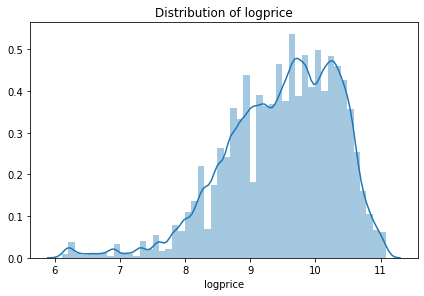

In [20]:
#The below graph shows the variation of price in the clean dataset:
sns.distplot(df4.logprice)
plt.tight_layout()
plt.title("Distribution of logprice")
plt.savefig('Insight-Dist-Plot',dpi=None)
plt.show()


-------------------------------------------------------------------------------------------------------------------------------
Data Visualization
-------------------------------------------------------------------------------------------------------------------------------

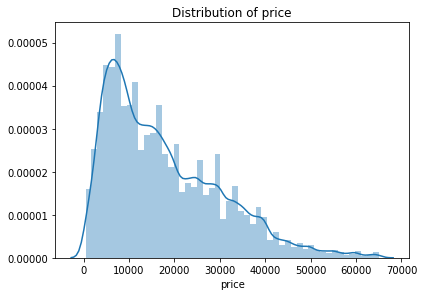

In [16]:
#The below graph shows the variation of price in the clean dataset:
sns.distplot(df4.price)
plt.tight_layout()
plt.title("Distribution of price")
plt.savefig('Insight-Dist-Plot',dpi=None)
plt.show()

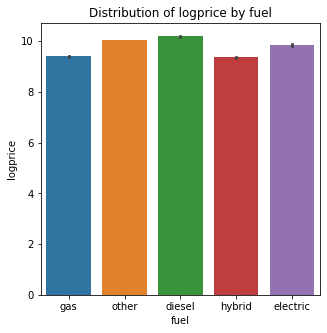

In [21]:
#The below graph shows the variation of price as per the fuel in it
fig,axs=plt.subplots()
fig.set_size_inches(5,5)
_
p1=sns.barplot(x='fuel',y='logprice',data=df4,ax=axs)
axs.set_title('Distribution of logprice by fuel')
plt.show()


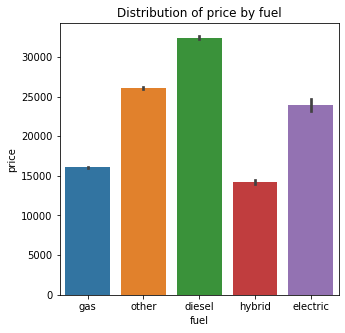

In [22]:
#The below graph shows the variation of price as per the fuel in it
fig,axs=plt.subplots()
fig.set_size_inches(5,5)
_
p1=sns.barplot(x='fuel',y='price',data=df4,ax=axs)
axs.set_title('Distribution of price by fuel')
plt.show()

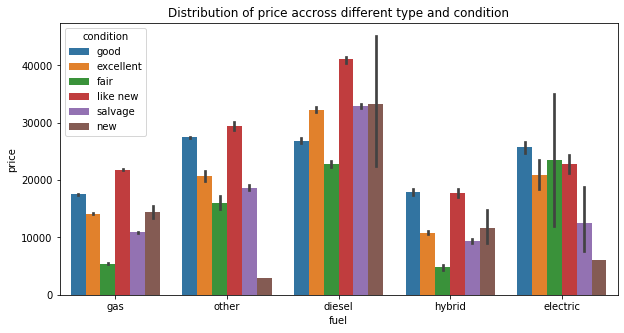

In [6]:
#The below graph shows the distribution of price across different fuel types and corresponding condition
plt.figure(figsize=(10,5))
sns.barplot(x='fuel',y='price',hue='condition',data=df4)
plt.title('Distribution of price accross different type and condition')
plt.show()


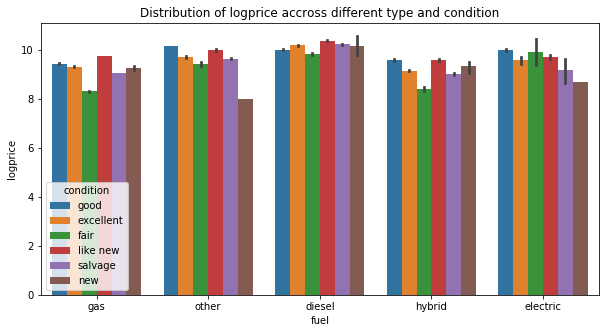

In [24]:
plt.figure(figsize=(10,5))
sns.barplot(x='fuel',y='logprice',hue='condition',data=df4)
plt.title('Distribution of logprice accross different type and condition')
plt.show()

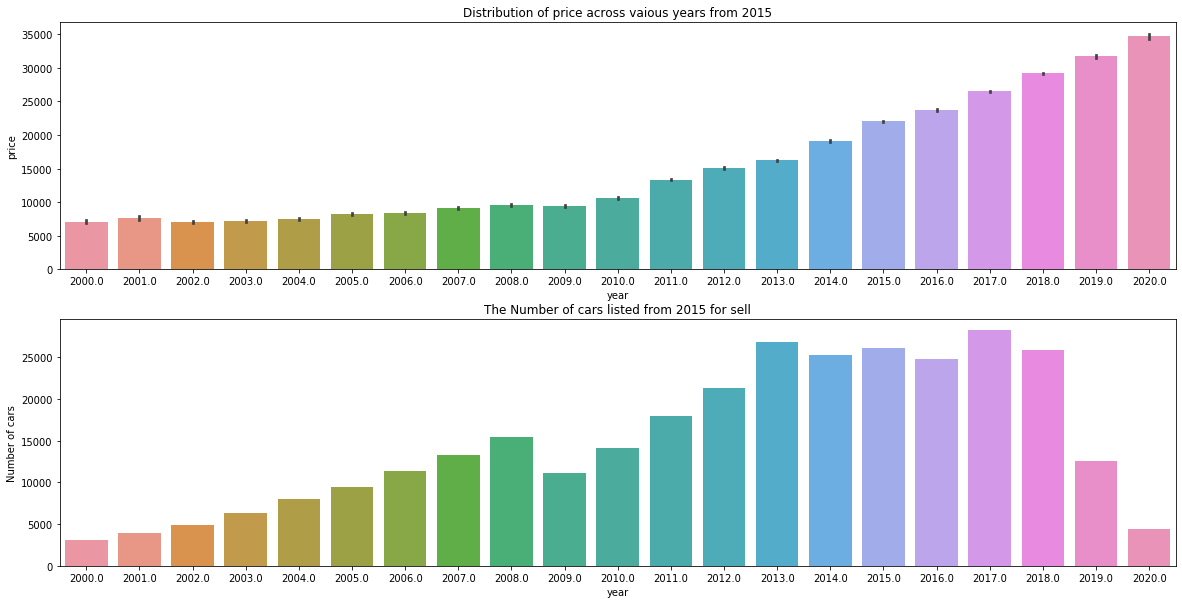

In [9]:

fig,axs=plt.subplots(nrows=2)
fig.set_size_inches(20,10)
sns.barplot(x='year',y='price',data=df4,ax=axs[0])
sns.barplot(df4.groupby('year').count()['price'].index,df4.groupby('year').count()['price'].values,ax=axs[1])
#plt.title('Distribution of price and the number of cars accross different years')
axs[0].set_title('Distribution of price across vaious years from 2015')
axs[1].set_title('The Number of cars listed from 2015 for sell')
axs[1].set_ylabel('Number of cars')
plt.show()


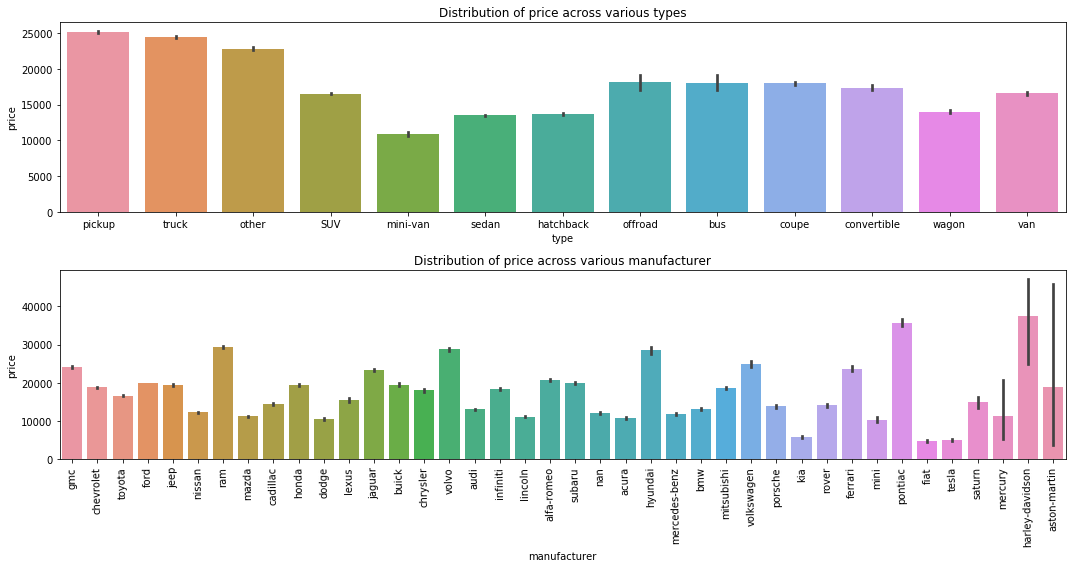

In [11]:

fig,axs=plt.subplots(nrows=2)
fig.set_size_inches(15,8)
sns.barplot(x='type',y='price',data=df4,ax=axs[0])
sns.barplot(x='manufacturer',y='price',data=df4,ax=axs[1])
axs[1].set_xticklabels(df.manufacturer.unique(),rotation=91)
axs[0].set_title('Distribution of price across various types')
axs[1].set_title('Distribution of price across various manufacturer')
plt.tight_layout()
plt.show()


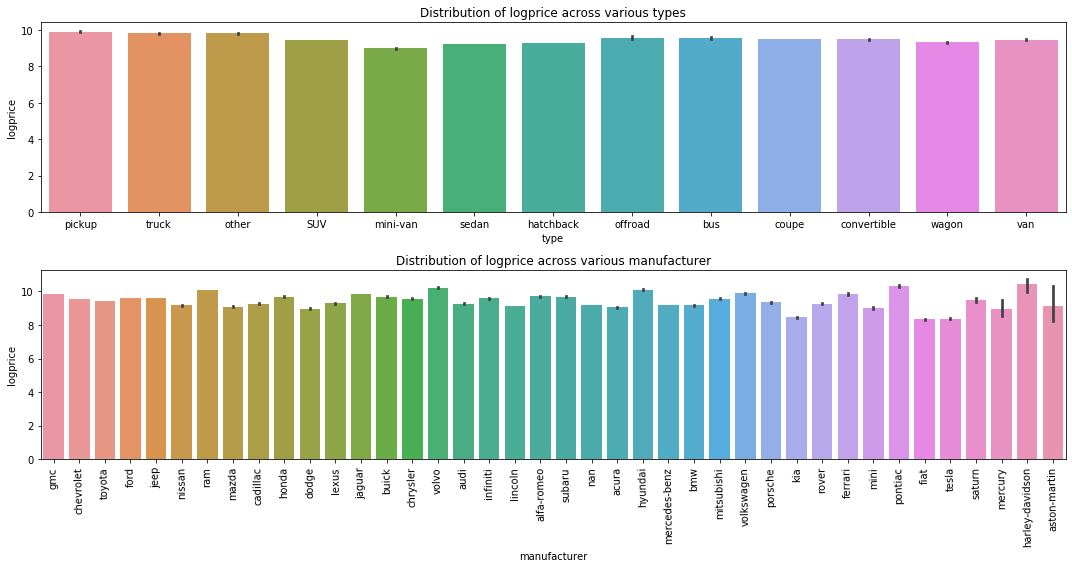

In [25]:

fig,axs=plt.subplots(nrows=2)
fig.set_size_inches(15,8)
sns.barplot(x='type',y='logprice',data=df4,ax=axs[0])
sns.barplot(x='manufacturer',y='logprice',data=df4,ax=axs[1])
axs[1].set_xticklabels(df.manufacturer.unique(),rotation=91)
axs[0].set_title('Distribution of logprice across various types')
axs[1].set_title('Distribution of logprice across various manufacturer')
plt.tight_layout()
plt.show()


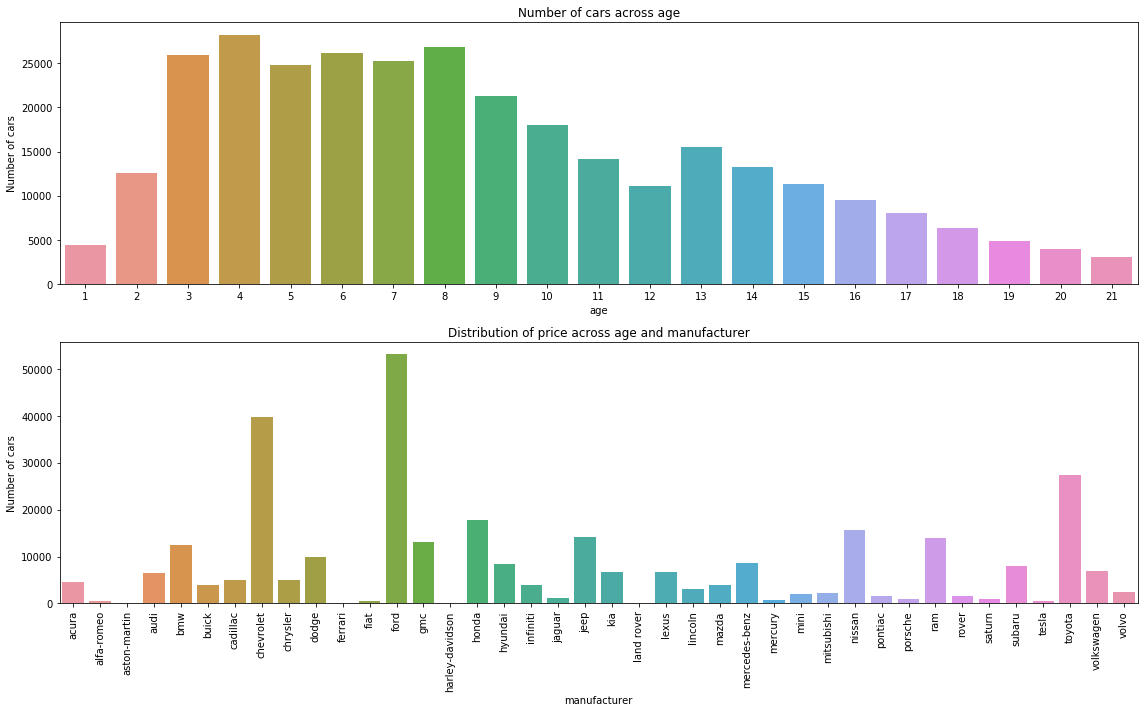

In [29]:
fig,axs=plt.subplots(nrows=2)
fig.set_size_inches(16,10)
sns.barplot(df4.groupby('age').count()['price'].index,df4.groupby('age').count()['price'].values,ax=axs[0])
sns.barplot(df4.groupby('manufacturer').count()['price'].index,df4.groupby('manufacturer').count()['price'].values,ax=axs[1])
axs[0].set_ylabel('Number of cars')
axs[0].set_title('Number of cars across age')
axs[1].set_ylabel('Number of cars')
axs[1].set_title('Distribution of price across age and manufacturer')
axs[1].set_xticklabels(df4.groupby('manufacturer').count()['price'].index,rotation=90)
plt.tight_layout()
plt.show()


In [14]:
state_counts = df4.groupby('state').agg({'logprice': 'median', 'state': 'size'})
state_counts.columns = ['Price', 'Size']
#state_counts['State'] = state_counts['State'].str.upper()
state_counts

state_counts.reset_index(drop=False, inplace=True)

state_counts

state_counts['state'] = state_counts['state'].str.upper()

state_counts



,state,Price,Size
0,AK,9.998411,2762
1,AL,9.830379,3674
2,AR,9.792556,2589
3,AZ,9.679719,6266
4,CA,9.583833,35726
5,CO,9.695725,8455
6,CT,9.209840,4256
7,DC,9.433084,2276
8,DE,9.158521,731
9,FL,9.588571,21382


In [19]:
import plotly.graph_objs as go
from plotly.offline import iplot

# define a data object and a colorscale
data = dict(type='choropleth',
            locations=state_counts['state'],
            locationmode="USA-states",
            z=state_counts['Price'],
            text=state_counts['state'],
            colorbar={'title': 'Price'},
            colorscale=[[0, 'rgb(31,125,180)'],
                        [0.1, 'rgb(51,160,44)'],
                        [0.50, 'rgb(255,255,20)'],
                        [1, 'rgb(210,26,28)']],
            reversescale = False)

# define a layout object
layout = dict(title='Number of listings by state',
              autosize=False,
              width=800,
              height=800,
              geo=dict(showframe=True, scope ="usa"))

car_map = go.Figure(data=[data], layout=layout)
iplot(car_map, validate=False)


In [18]:
import plotly.graph_objs as go
from plotly.offline import iplot

# define a data object and a colorscale
data = dict(type='choropleth',
            locations=state_counts['state'],
            locationmode="USA-states",
            z=state_counts['Size'],
            text=state_counts['state'],
            colorbar={'title': 'Size'},
            colorscale=[[0, 'rgb(31,125,180)'],
                        [0.1, 'rgb(51,160,44)'],
                        [0.50, 'rgb(255,255,20)'],
                        [1, 'rgb(210,26,28)']],
            reversescale = False)

# define a layout object
layout = dict(title='Median price of cars by state',
              autosize=False,
              width=800,
              height=800,
              geo=dict(showframe=True, scope ="usa"))

car_map = go.Figure(data=[data], layout=layout)
iplot(car_map, validate=False)